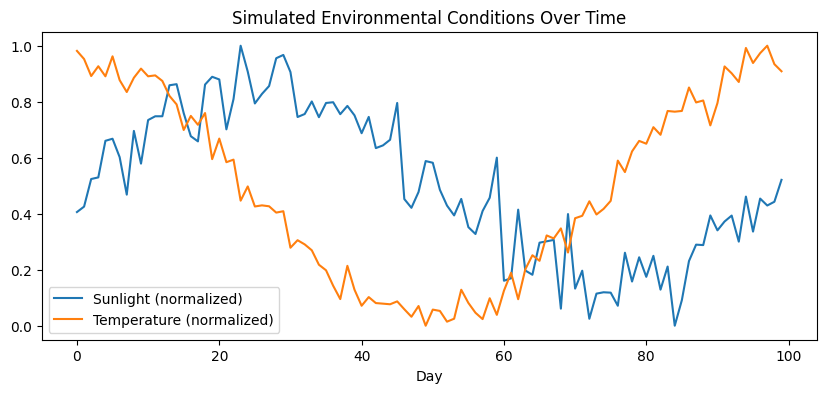

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
torch.manual_seed(0)

days = 100

# Simulate environmental variables
sunlight = 6 + 2 * torch.sin(torch.linspace(0, 3.14 * 2, days)) + torch.randn(days) * 0.5
temperature = 22 + 5 * torch.cos(torch.linspace(0, 3.14 * 2, days)) + torch.randn(days) * 0.5

# Normalize
sunlight = (sunlight - sunlight.min()) / (sunlight.max() - sunlight.min())
temperature = (temperature - temperature.min()) / (temperature.max() - temperature.min())

# Combine into a feature tensor
env_features = torch.stack((sunlight, temperature), dim=1)

# Visualize
plt.figure(figsize=(10, 4))
plt.plot(sunlight, label='Sunlight (normalized)')
plt.plot(temperature, label='Temperature (normalized)')
plt.title("Simulated Environmental Conditions Over Time")
plt.xlabel("Day")
plt.legend()
plt.show()

In [ ]:
# Trait: Height only (simplified)
noise = torch.randn(days) * 0.1
height = 0.5 * sunlight + 0.5 * temperature + noise
height = height.unsqueeze(1)

In [ ]:
import torch.nn as nn

class PlantLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # Last timestep prediction

In [ ]:
# Prepare dataset: sliding window
seq_len = 10
X = []
y = []

for i in range(len(env_features) - seq_len):
    X.append(env_features[i:i+seq_len])
    y.append(height[i+seq_len])

X = torch.stack(X)
y = torch.stack(y)

# Train-test split
train_X, train_y = X[:80], y[:80]
test_X, test_y = X[80:], y[80:]

# Model
model = PlantLSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    output = model(train_X)
    loss = loss_fn(output, train_y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.2086
Epoch 20, Loss: 0.0215
Epoch 40, Loss: 0.0143
Epoch 60, Loss: 0.0137
Epoch 80, Loss: 0.0135
Epoch 100, Loss: 0.0134
Epoch 120, Loss: 0.0133
Epoch 140, Loss: 0.0131
Epoch 160, Loss: 0.0129
Epoch 180, Loss: 0.0127


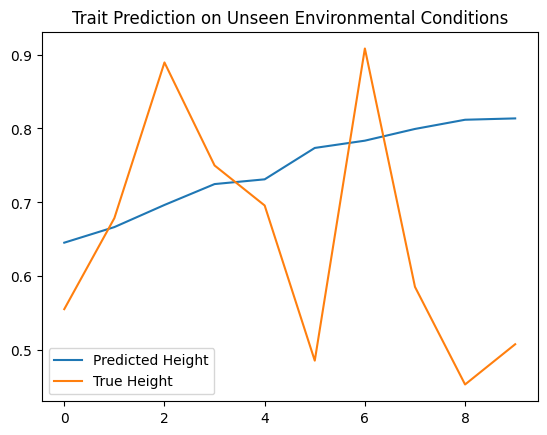

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(test_X).squeeze()
    true_vals = test_y.squeeze()

plt.plot(preds.numpy(), label="Predicted Height")
plt.plot(true_vals.numpy(), label="True Height")
plt.legend()
plt.title("Trait Prediction on Unseen Environmental Conditions")
plt.show()